Litchi detected : 2
fresh Litchi : 1  |  non-fresh Litchi : 1
Percetage of Fresh Litchi : 50.0 %


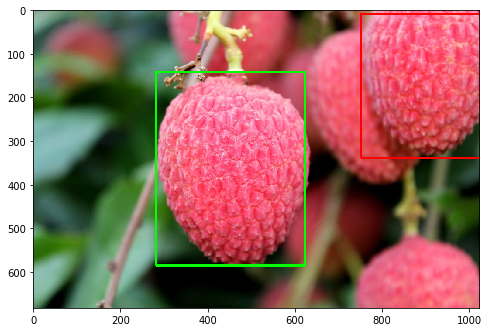

Litchi detected : 8
fresh Litchi : 7  |  non-fresh Litchi : 1
Percetage of Fresh Litchi : 87.5 %


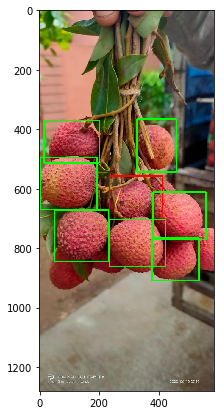

Litchi detected : 10
fresh Litchi : 4  |  non-fresh Litchi : 6
Percetage of Fresh Litchi : 40.0 %


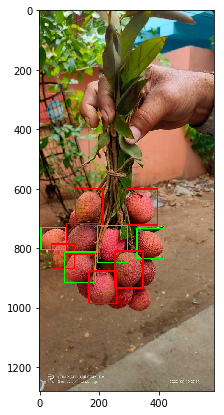

Litchi detected : 12
fresh Litchi : 6  |  non-fresh Litchi : 6
Percetage of Fresh Litchi : 50.0 %


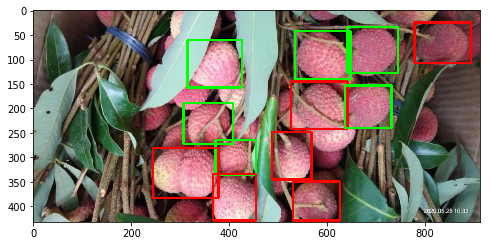

Litchi detected : 15
fresh Litchi : 11  |  non-fresh Litchi : 4
Percetage of Fresh Litchi : 73.3 %


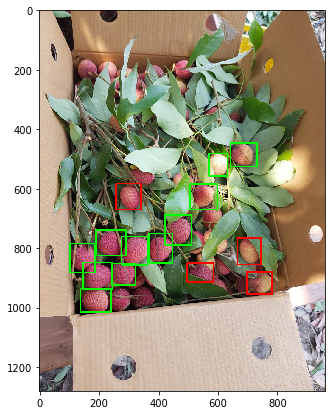

Litchi detected : 10
fresh Litchi : 7  |  non-fresh Litchi : 3
Percetage of Fresh Litchi : 70.0 %


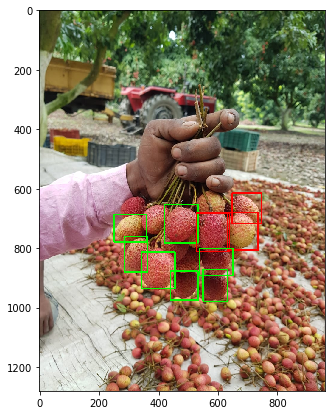

Litchi detected : 9
fresh Litchi : 8  |  non-fresh Litchi : 1
Percetage of Fresh Litchi : 88.9 %


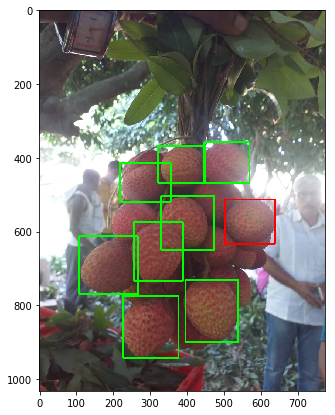

Litchi detected : 14
fresh Litchi : 7  |  non-fresh Litchi : 7
Percetage of Fresh Litchi : 50.0 %


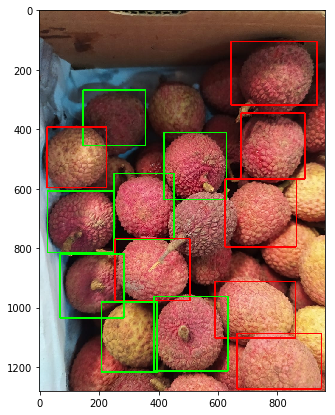

Litchi detected : 16
fresh Litchi : 15  |  non-fresh Litchi : 1
Percetage of Fresh Litchi : 93.8 %


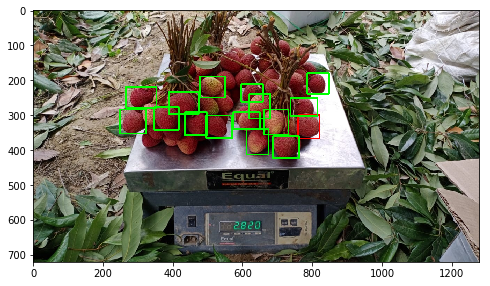

Litchi detected : 6
fresh Litchi : 6  |  non-fresh Litchi : 0
Percetage of Fresh Litchi : 100.0 %


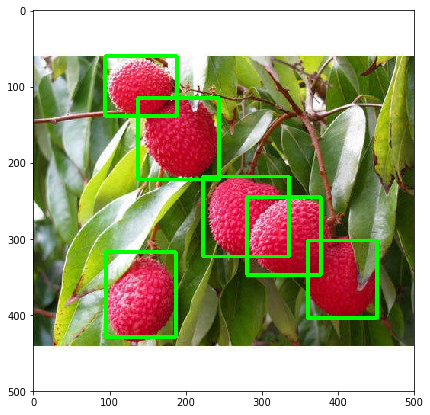

Litchi detected : 14
fresh Litchi : 11  |  non-fresh Litchi : 3
Percetage of Fresh Litchi : 78.6 %


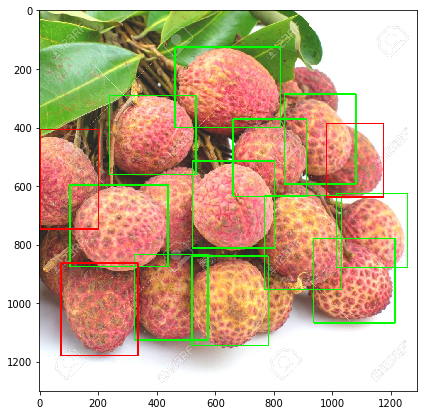

Litchi detected : 9
fresh Litchi : 6  |  non-fresh Litchi : 3
Percetage of Fresh Litchi : 66.7 %


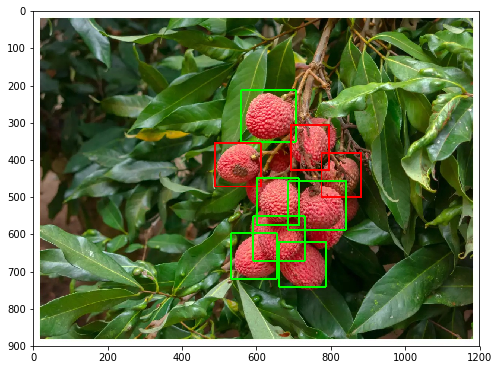

Litchi detected : 18
fresh Litchi : 12  |  non-fresh Litchi : 6
Percetage of Fresh Litchi : 66.7 %


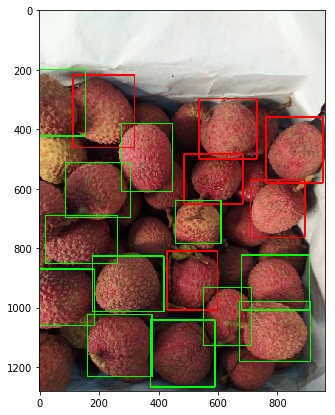

Litchi detected : 6
fresh Litchi : 1  |  non-fresh Litchi : 5
Percetage of Fresh Litchi : 16.7 %


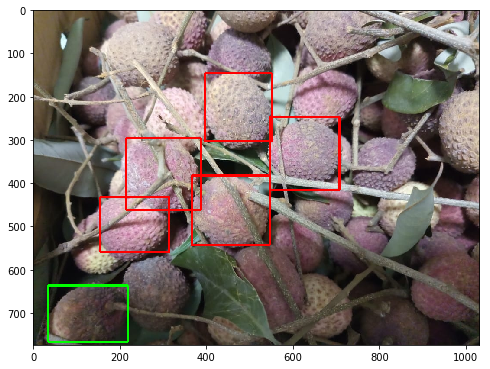

Litchi detected : 12
fresh Litchi : 12  |  non-fresh Litchi : 0
Percetage of Fresh Litchi : 100.0 %


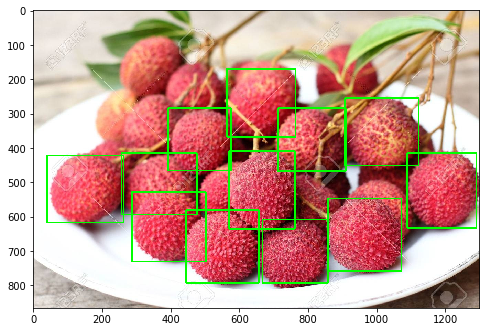

Litchi detected : 9
fresh Litchi : 5  |  non-fresh Litchi : 4
Percetage of Fresh Litchi : 55.6 %


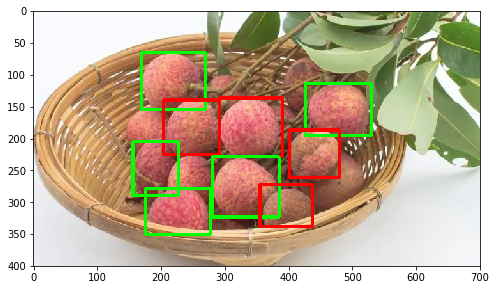

Litchi detected : 18
fresh Litchi : 15  |  non-fresh Litchi : 3
Percetage of Fresh Litchi : 83.3 %


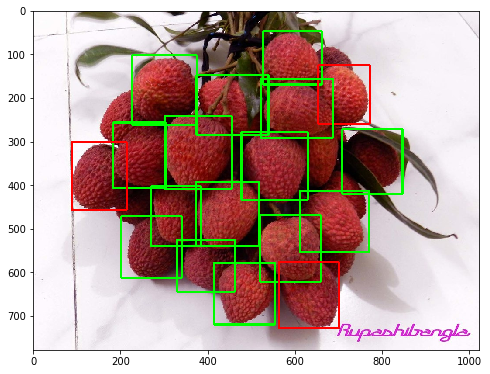

Litchi detected : 8
fresh Litchi : 2  |  non-fresh Litchi : 6
Percetage of Fresh Litchi : 25.0 %


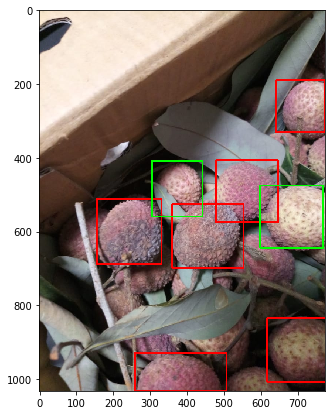

Litchi detected : 2
fresh Litchi : 2  |  non-fresh Litchi : 0
Percetage of Fresh Litchi : 100.0 %


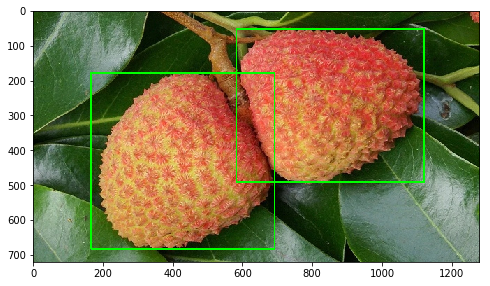

No detection


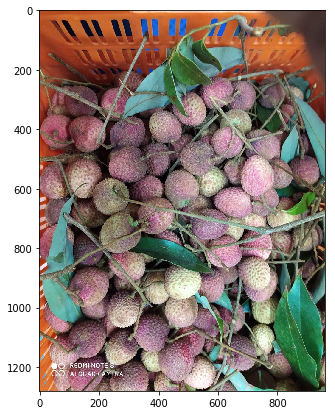

In [ ]:
import cv2
import numpy as np
import glob
import random
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

#load spoilage model
#specify the path where the spoilage_allimg_vgg16.h5 model is located
model=tf.keras.models.load_model('D:\srinivas\data analytics\datasets\Ecozen\ecozen\litchi\classification\spoilage_allimg_vgg16.h5',compile=False)

# Load Yolo
#specify the path where yolo model is located
weightspath="D:\srinivas\data analytics\datasets\Ecozen\ecozen\litchi\model\litchi_last.weights"
#specify the yolov3_testing.cfg path
net = cv2.dnn.readNet(weightspath, "yolov3_testing.cfg")

# Name custom object
classes = ["litchi"]

# Images path
images_path=glob.glob(r'D:\srinivas\data analytics\datasets\Ecozen\ecozen\litchi\img1\*.jpeg')


layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
colors = np.random.uniform(0, 255, size=(len(classes), 3))

# Insert here the path of your images
random.shuffle(images_path)
#storing bbox of each fruit in a list
all_img=[]
# loop through all the images
for img_path in images_path:
    # Loading image
    img = cv2.imread(img_path)
    #img = cv2.resize(img, (600,500))
    img_copy=np.copy(img)
    height, width, channels = img.shape

    # Detecting objects
    blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

    net.setInput(blob)
    outs = net.forward(output_layers)

    # Showing informations on the screen
    class_ids = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.2: # higher confidence : will detect objects which have high probaility of being litchi
                # Object detected
                #print(class_id)
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                # Rectangle coordinates
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    font = cv2.FONT_HERSHEY_PLAIN
    num_of_litchi=0 ##counting litchi in img
    fresh=0
    notfresh=0
    one_img=[]
    pred=0
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            crop_img=img_copy[y:y+h,x:x+w]
            one_img.append(crop_img) ## append each litchi image
            label = str(classes[class_ids[i]])
            #print("confidence : ",confidences[i])
            num_of_litchi+=1
#             x_centre=int(x+w/2)
#             y_centre=int(y+h/2)
#             radius=int((w+h)/4)
#             cv2.circle(img,(x_centre,y_centre),radius,(0,0,255),2)
            
            #spoilage prediction
            if((crop_img.shape[0]!=0) & (crop_img.shape[1]!=0) & (crop_img.shape[2]!=0)):
                crop_img=cv2.resize(crop_img,(150,150))
                crop_img=crop_img/255
                crop_img=np.expand_dims(crop_img,0)
                pred=(model.predict(crop_img)[0][1])
            
            if pred>0.75:  #probability can be changed to change how many defective are detected 
                notfresh+=1
                cv2.rectangle(img, (x, y), (x + w, y + h),(0,0,255), 3)
            else:
                fresh+=1
                cv2.rectangle(img, (x, y), (x + w, y + h),(0,255,0), 3)
            #cv2.putText(img, label, (x, y - 10), font, 1,(255,0,0), 2)
        
    if num_of_litchi>0:
        print("Litchi detected :",num_of_litchi)
        print("fresh Litchi :",fresh," | ","non-fresh Litchi :",notfresh)
        print("Percetage of Fresh Litchi :",np.round(fresh*100/num_of_litchi,1),'%')
    else:
        print("No detection")
    all_img.append(one_img)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8,7))
    plt.imshow(img)
    plt.show()


In [ ]:
#plt.imshow(cv2.cvtColor(all_img[9][8],cv2.COLOR_BGR2RGB))

# saving the cropped images in a folder

In [ ]:
# j=1
# path=r"D:\srinivas\data analytics\datasets\Ecozen\ecozen\litchi\rotten_pred"
# for image in all_img:
#     for each in image:
#         if((each.shape[0]!=0) & (each.shape[1]!=0) & (each.shape[2]!=0)):
#             name=path +"\img"+str(j)+".jpeg"
#             j+=1
#             each=cv2.resize(each,(150,150))
#             cv2.imwrite(name,each)
#             plt.imshow(each)
#             plt.show()

# Coverting to jpeg format

In [ ]:
path=glob(r'D:\srinivas\data analytics\datasets\Ecozen\ecozen\litchi\img2\*')

j=1
for i in range(len(path)):
    img=cv2.imread(path[i])
    j=j+1
    savepath="D:\srinivas\data analytics\datasets\Ecozen\ecozen\litchi\img2\jp"
    name=savepath +"\img" + str(j) + ".jpeg"
    cv2.imwrite(name,img)